In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/2022/classes/stat195/stat195project')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/2022/classes/stat195/stat195project


In [3]:
%%capture
!pip install lassonet

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append("aav/util")

from lassonet import LassoNetClassifier

from residue_encoding import ResidueIdentityEncoder
from mutation_encoding import MutationSequenceEncoder

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from tqdm.auto import tqdm


# Data

## Examine Dataset

In [5]:
df = pd.read_csv("stat_195_project_data.csv")
df.head()

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
0,ADEEIRATNPIATEMYGSVSTNLQLGNR,designed,AD____A___I___M_________L___,6,6,-2.027259,False
1,ADEEIRATNPVATEQYGSVSTNQQRQNR,designed,AD____A_______________Q__Q__,5,5,-0.429554,True
2,ADEEIRTTNPVATEQWGGVSTNLQIGNY,designed,AD_____________W_G______I__Y,6,6,-0.527843,True
3,ADEEIRTTNPVATEQYGEVSTNLQRGNR,designed,AD_______________E__________,3,3,2.887908,True
4,ADEEIRTTNPVATEQYGSVSTNLQRGNR,designed,AD__________________________,2,2,0.575730,True


In [6]:
# print unique partitions
sorted(df["partition"].unique())

['cnn_designed_plus_rand_train_seed',
 'cnn_designed_plus_rand_train_walked',
 'cnn_rand_doubles_plus_single_seed',
 'cnn_rand_doubles_plus_single_walked',
 'cnn_standard_seed',
 'cnn_standard_walked',
 'designed',
 'lr_designed_plus_rand_train_seed',
 'lr_designed_plus_rand_train_walked',
 'lr_rand_doubles_plus_single_seed',
 'lr_rand_doubles_plus_single_walked',
 'lr_standard_seed',
 'lr_standard_walked',
 'previous_chip_nonviable',
 'previous_chip_viable',
 'rand',
 'random_doubles',
 'rnn_designed_plus_rand_train_seed',
 'rnn_designed_plus_rand_train_walked',
 'rnn_rand_doubles_plus_singles_seed',
 'rnn_rand_doubles_plus_singles_walked',
 'rnn_standard_seed',
 'rnn_standard_walked',
 'single',
 'singles',
 'stop',
 'wild_type']

In [7]:
len(df[df["partition"] == "designed"]) # additive model A_39 (complete)

56372

In [8]:
len(df[df["partition"] == "single"]) # complete singles C_1 (complete)

1112

In [14]:
len(df[df["partition"] == "random_doubles"]) # superset of R_2, which has n=1756 data points

25040

In [15]:
len(df[df["partition"] == "rand"]) # R_10 + validation dataset 
# R_10 has 7908 randomly generated mutants (2-10 mutations)
# validation dataset has 1977 mutants

9885

In [12]:
for num_mutations in range(2, 11):
    print("number of mutations:", num_mutations)
    print(len(df[(df["partition"] == "rand") & (df["num_mutations"] == num_mutations)]))

number of mutations: 2
1756
number of mutations: 3
1751
number of mutations: 4
1745
number of mutations: 5
1745
number of mutations: 6
1732
number of mutations: 7
288
number of mutations: 8
289
number of mutations: 9
290
number of mutations: 10
289


## Define datasets
- $C_1 + R_2$ dataset
- $C_1 + R_{10}$ dataset
- $R_{10} + A_{39}$ dataset
- holdout 1977 random multiples

In [46]:
# create validation dataset and r10 dataset
r10_plus_val = df[df["partition"] == "rand"]
val_df = r10_plus_val.sample(n=1977, replace=False, random_state=195)
r10 = r10_plus_val.drop(val_df.index)

for num_mutations in range(2, 11):
    print("number of mutations:", num_mutations)
    print(len(val_df[val_df["num_mutations"] == num_mutations]))

number of mutations: 2
323
number of mutations: 3
319
number of mutations: 4
359
number of mutations: 5
373
number of mutations: 6
366
number of mutations: 7
54
number of mutations: 8
59
number of mutations: 9
57
number of mutations: 10
67


In [19]:
# create r2 dataset
r2 = df[df["partition"] == "rand"].sample(n=1756, replace=False, random_state=195)

In [20]:
c1 = df[df["partition"] == "single"]

In [21]:
a39 = df[df["partition"] == "designed"]

In [57]:
# create train datasets
c1_r2 = pd.concat([c1, r2]).reset_index()
print(f"C1+R2 size: {len(c1_r2)}")

c1_r10 = pd.concat([c1, r10]).reset_index()
print(f"C1+R10 size: {len(c1_r10)}")

r10_a39 = pd.concat([r10, a39]).reset_index()
print(f"R10+A39 size: {len(r10_a39)}")

val_df.reset_index(inplace=True)
print(f"Validation size: {len(val_df)}")

C1+R2 size: 2868
C1+R10 size: 9020
R10+A39 size: 64280
Validation size: 1977


In [37]:
# The canonical single-letter code residue alphabet.
RESIDUES = tuple('ACDEFGHIKLMNPQRSTVWY')

# The AAV serotype 2 wild type subsequence corresponding to positions 561 to 588
R1_TILE21_WT_SEQ = 'DEEEIRTTNPVATEQYGSVSTNLQRGNR'

res_encoder = ResidueIdentityEncoder(alphabet=RESIDUES)
mut_encoder = MutationSequenceEncoder(res_encoder, R1_TILE21_WT_SEQ)

# Train LassoNet Model

In [65]:
NUM_MODELS = 2 # number of models per ensemble

In [72]:
sum(y_val)/len(y_val)

0.09307030854830552

  0%|          | 0/2 [00:00<?, ?it/s]

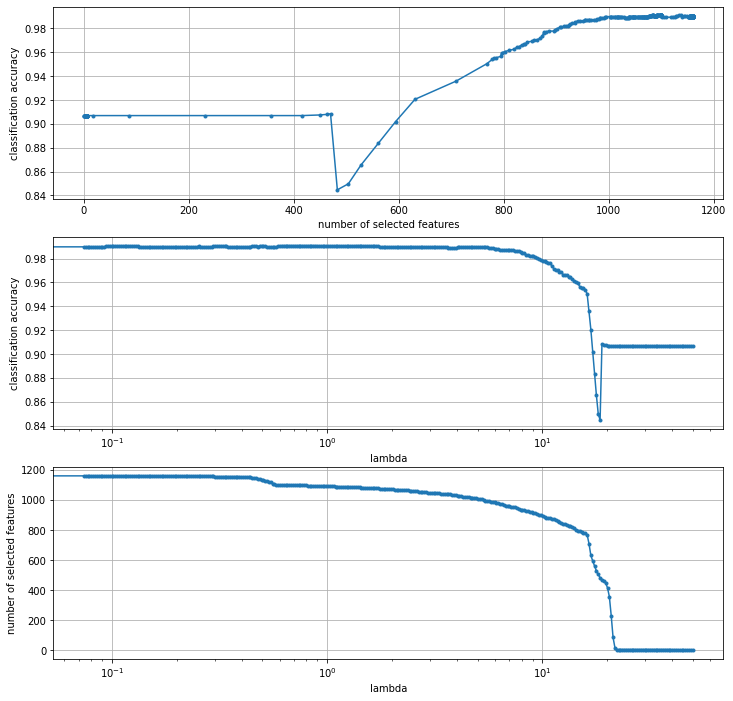

In [70]:
X_val = []
for i in range(len(val_df)):
    X_val.append(mut_encoder.encode(val_df["sequence"][i]))
X_val = np.array(X_val)
X_val = X_val.reshape(len(X_val), -1)
y_val = val_df["is_viable"].to_numpy().astype(int)

# for data, name in zip([c1_r2, c1_r10, r10_a39], ["c1_r2", "c1_r10", "r10_a39"]):
# iterate through 3 possible training sets

for data, name in zip([c1_r2], ["c1_r2"]):
    X_train = []
    for i in range(len(data)):
        X_train.append(mut_encoder.encode(data["sequence"][i]))
    y_train = data["is_viable"].to_numpy().astype(int)
    X_train = np.array(X_train)

    X_train = X_train.reshape(len(X_train), -1)

    # define ensemble of models
    models = [None]*NUM_MODELS
    paths = [None]*NUM_MODELS
    
    # train models
    for i in tqdm(range(NUM_MODELS)):
        models[i] = LassoNetClassifier(M=30, hidden_dims=(1,))
        paths[i] = models[i].path(X_train, y_train, X_val=X_val, y_val=y_val)

        n_selected = []
        accuracy = []
        lambda_ = []

        for save in paths[i]:
            models[i].load(save.state_dict)
            y_pred = models[i].predict(X_val)
            n_selected.append(save.selected.sum())
            accuracy.append(accuracy_score(y_val, y_pred))
            lambda_.append(save.lambda_)    

        if i == NUM_MODELS - 1:
            # plot last model's performance
            fig = plt.figure(figsize=(12, 12))

            plt.subplot(311)
            plt.grid(True)
            plt.plot(n_selected, accuracy, ".-")
            plt.xlabel("number of selected features")
            plt.ylabel("classification accuracy")

            plt.subplot(312)
            plt.grid(True)
            plt.plot(lambda_, accuracy, ".-")
            plt.xlabel("lambda")
            plt.xscale("log")
            plt.ylabel("classification accuracy")

            plt.subplot(313)
            plt.grid(True)
            plt.plot(lambda_, n_selected, ".-")
            plt.xlabel("lambda")
            plt.xscale("log")
            plt.ylabel("number of selected features")

            plt.show()

In [115]:
n_selected = np.array(n_selected) # default sorted from greatest to least

idx = list(n_features < 600 for n_features in n_selected).index(True)

paths[1][idx].selected.reshape(29, 2, 20).numpy()

array([[[False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False,  True, False],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[False, False, False, ..., False,  True, False],
        [False,  True, False, ..., False,  True, False]],

       [[False,  True, False, ..., False,  True, False],
        [False, False,  True, ..., False,  True, False]],

       [[False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False,  True, False]]])

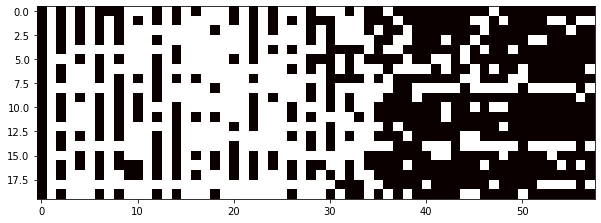

In [116]:
plt.figure(figsize=(10, 5))
plt.imshow(paths[1][idx].selected.reshape(29, 2, 20).reshape(58, 20).numpy().T, cmap='hot', interpolation='nearest')
plt.show()

# white pixels are 1 and black pixels are 0
# left: substitution, right: insertion

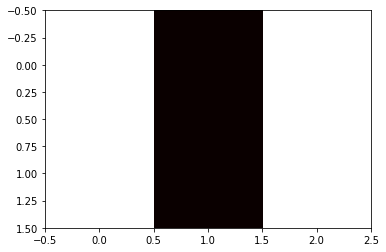

In [114]:
plt.imshow(np.array([[1, 0, 1], [1, 0, 1]]), cmap='hot', interpolation='nearest')
plt.show()